This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd # standard naming convention
import numpy as np

file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name, nrows=15000)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
14995,1,1,4,3869200316,3399,9
14996,1,1,17,3869200316,3400,15
14997,1,1,10,3869200316,3530,16
14998,1,1,8,3869200316,3533,18


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [3]:
df = data["BX_COUNTER"]
df

print("Max", max(df))

Max 3563


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [4]:
data["NANO_SEC"] = data["TDC_MEAS"]*25/30 + data["BX_COUNTER"]*25 + data["ORBIT_CNT"]*3563*25
data["NANO_SEC"] = data["NANO_SEC"] - data.loc[0]["NANO_SEC"]
print((data.loc[14999]["NANO_SEC"] - data.loc[0]["NANO_SEC"])*10**(-9))
data["NANO_SEC"]

0.013301278312500001


0        0.000000e+00
1        8.125000e-01
2        4.476625e+03
3        4.594125e+03
4        9.649125e+03
             ...     
14995    1.329779e+07
14996    1.329782e+07
14997    1.330107e+07
14998    1.330114e+07
14999    1.330128e+07
Name: NANO_SEC, Length: 15000, dtype: float64

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [5]:
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NANO_SEC
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
14995,1,1,4,3869200316,3399,9,1.329779e+07
14996,1,1,17,3869200316,3400,15,1.329782e+07
14997,1,1,10,3869200316,3530,16,1.330107e+07
14998,1,1,8,3869200316,3533,18,1.330114e+07


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
df = data.groupby(by='TDC_CHANNEL', sort=True).count()
df = df.sort_values('HEAD', ascending=False)
top = [x for x in df.index[0:3]]
print("3 TDC_CHANNELS is ", top)

3 TDC_CHANNELS is  [139, 64, 63]


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [7]:
count_nempty=0
count_fromtdc=0

for i in range(data['ORBIT_CNT'][0], data['ORBIT_CNT'][14999]):
    if i in list(zip(*data.values.tolist()))[3]:
        count_nempty+=1
        df = data.loc[(data['ORBIT_CNT'] == i) & (data['TDC_CHANNEL']==139)]
        if not df.empty: 
            count_fromtdc += 1
        
print(count_nempty)
print(count_fromtdc)

149
149


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

             HEAD  FPGA  ORBIT_CNT  BX_COUNTER  TDC_MEAS  NANO_SEC
TDC_CHANNEL                                                       
1             346   346        346         346       346       346
2             379   379        379         379       379       379
3             293   293        293         293       293       293
4             309   309        309         309       309       309
5             208   208        208         208       208       208
...           ...   ...        ...         ...       ...       ...
125             6     6          6           6         6         6
126             7     7          7           7         7         7
127            16    16         16          16        16        16
128            18    18         18          18        18        18
139          1268  1268       1268        1268      1268      1268

[129 rows x 6 columns]


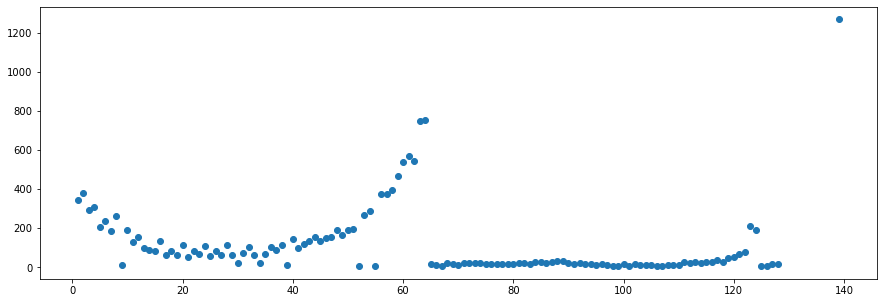

In [8]:
import matplotlib.pyplot as plt
df = data.groupby('TDC_CHANNEL').count()['HEAD']
x = [i for i in df.index]
y = [i for i in df.values]

fig = plt.figure(figsize=(15, 5))
plt.scatter(x,y)
print(data.groupby('TDC_CHANNEL').count())